In [1]:
import sys
#sys.path.append("/home/zoe/anaconda3/envs/arctic/lib/python3.6/site-packages/")
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy as c
from mpl_toolkits import mplot3d
from gsw import SA_from_SP
from gsw import CT_from_t
from gsw import rho
from gsw import alpha
import os
import gsw
import xarray as xr
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib.patches as mpatches
import matplotlib.path as mpath
import matplotlib.cm as cm
import matplotlib as mpl
import scipy.io as io

In [2]:
path='/Users/zcaspar/Documents/Stage/ITP/'
file_topo='/Users/zcaspar/Documents/Stage/grl/Topo/etopo4.mat'


In [3]:
#Functions 
def topography(topo_file):
    f=io.loadmat(topo_file)
    lat=f['etopo360'][0][0][0]
    lon=f['etopo360'][0][0][1]
    topo=f['etopo360'][0][0][2]
    # Read data from: http://coastwatch.pfeg.noaa.gov/erddap/griddap/usgsCeSrtm30v6.html
    return lat,lon,topo

#Calcul distance cumulé:

def distance_sphere(lat0,lon0,latf,lonf):
    lat0=lat0*np.pi/180
    latf=latf*np.pi/180
    lon0=lon0*np.pi/180
    lonf=lonf*np.pi/180
    return 6371.01 * np.arccos(np.sin(lat0)*np.sin(latf) + np.cos(lat0)*np.cos(latf)*np.cos(lon0 - lonf))

def cumul_dist(lat,lon,lat0,lon0):
    dist=distance_sphere(lat0,lon0,lat[1],lon[1])
    Dist=[0,dist]
    lat1=lat[1]
    lon1=lon[1]
    for i in range(2,lat.size):
        dist+=distance_sphere(lat1,lon1,lat[i],lon[i])
        Dist.append(dist)
        lat1=lat[i]
        lon1=lon[i]
    return dist,Dist


In [4]:
def read_itp(file):
    ds = xr.open_dataset(file,decode_times=False)
    ds = ds.assign_coords({'lon':ds['LONGITUDE'],'lat':ds['LATITUDE'],'levels':ds['BIN']})
    t0 = ds.REFERENCE_DATE_TIME.values.tolist().decode('utf-8')
    ds = ds.where(ds.JULD<700000,drop=True)
    ds = ds.assign(time=pd.to_datetime(ds.JULD.values,origin='-'.join([t0[:4],t0[4:6],t0[6:8]]),unit='D'))
    ds = ds.set_index(N_PROF='time')
    ds = ds.set_index(N_LEVELS='levels').rename({'N_PROF':'time','N_LEVELS':'levels'})
    id_itp = file.split('_')[1]
#    if expand_dims:
#        ds = ds.expand_dims(dim='id').assign_coords({'id':np.array([int(id_itp)])})
#    else:
#        ds.assign_coords({'id':np.array([int(id_itp)])})
    return ds,id_itp

In [5]:
#Zone à observer:
lonmax=-120
lonmin=-160
latmin=65
latmax=85

#Période de temps voulue pour les ITP:
year0=2008
year1=2013
month0=1
month1=12

### List of sub dataset for each itp

In [6]:
#Recherche ITP zone voulue et période voulue:
import glob
import datetime
list_itp={}
for file in glob.glob(path+'*L3*.nc'):
    ds, id_itp = read_itp(file)
    try :
        ds_sub = ds.sel(time=slice(datetime.datetime(year0,month0,1),datetime.datetime(year1,month1,30)))
        pass
    except:
        print('Ooops')
    else:
        ds_sub = ds_sub.where(np.logical_and(ds_sub.lon >= lonmin, ds_sub.lon <= lonmax),drop=True)
        ds_sub = ds_sub.where(np.logical_and(ds_sub.lat >= latmin, ds_sub.lat <= latmax),drop=True)
        if ds_sub.levels.size==0:
            pass
        #    print(file)
        else:
            if ds_sub.time.size==0:
                pass
            else:
                list_itp['%s'%str(id_itp)]= ds_sub


Ooops
Ooops
Ooops
Ooops
Ooops
Ooops


In [7]:
print('Number of ITPs : ',len(list_itp.keys()))
print('--------------------------------------')
print('Grid levels step (for each itp): ',[list_itp[itp].levels.diff(dim='levels').mean().values.tolist() for itp in list_itp])

Number of ITPs :  27
--------------------------------------
Grid levels step (for each itp):  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


## Select data from cruises for needed years (and at the moorings)

In [8]:
import locale,re,seawater
locale.setlocale(locale.LC_ALL,'en_US')
def readHydrographicSurvey(rootFolder='/Users/zcaspar/Documents/Stage/grl/data_ctd/2006/1db_down/'):
 
  files =np. sort(glob.glob(rootFolder+'d*.cnv'))
  data = []
  n = 0
  for i,f in enumerate(files):
    print (f)
    for line in open(f,'rb').readlines():
      if b'Latitude' in line:
        #lat =  line[18:-4].split(' ');  lat =  float(lat[0]) + float(lat[1])/60. 
        lat =  [int(s) for s in re.split(b"[^0-9]",line) if s.isdigit()];  lat =  float(lat[0]) + float(lat[1]+lat[2]/100.)/60. 
      if b'Longitude' in line:
        #lon =  line[19:-4].split(' '); lon = -float(lon[0]) + float(lon[1])/60. 
        lon =  [int(s) for s in re.split(b"[^0-9]",line) if s.isdigit()];  lon = -float(lon[0]) + float(lon[1]+lon[2]/100.)/60. 
      if b'= prDM:' in line:
        pressureCol = int(line.split(b' ')[2])
#      if b'= depSM:' in line:
#        depthCol = int(line.split(b' ')[2])
      if b'= t090C:' in line:
        tempCol = int(line.split(b' ')[2])
      if b'= sal00:' in line:
        saltCol = int(line.split(b' ')[2])
      if b'= potemp090C:' in line:
        potempCol = int(line.split(b' ')[2])
      if (b'NMEA UTC' in line) | (b'UTC (Time):' in line):
        match = re.search(rb'.{3} \d{2} \d{4} *\d{2}:\d{2}:\d{2}', line)
        date = datetime.datetime.strptime(match.group().decode("utf-8"), '%b %d %Y  %H:%M:%S')
        print (date)
      if b'nvalues' in line:
        nvalues = re.search(rb'\d+',line).group()

    

    if (int(nvalues) > 2) | (nvalues==None):  
#      pressure,depth,temperature,salinity,pottemp = loadtxt(f,comments=['#','*'],usecols=(pressureCol,depthCol,tempCol,saltCol,potempCol),encoding='latin1',unpack=True)
      pressure,temperature,salinity,pottemp = np.loadtxt(f,comments=['#','*'],usecols=(pressureCol,tempCol,saltCol,potempCol),encoding='latin1',unpack=True)  
      rho = seawater.dens(salinity,temperature,pressure)
      rho0 = seawater.pden(salinity,temperature,pressure)
      N2,q,p_ave  = seawater.bfrq(salinity,temperature,pressure,lat)

      data.append(

         xr.Dataset(

          data_vars={

            'salt'                        : (['time','pressure'],[salinity]),   

            'temp'                        : (['time','pressure'],[temperature]),

            'rho'                         : (['time','pressure'],[rho]),        

            'rho0'                        : (['time','pressure'],[rho0]),       

            'N2'                          : (['time','pressureN2'],N2.T),

            'planetaryPotentialVorticity' : (['time','pressureN2'],q.T),
            
            'pottemp'                     : (['time','pressure'],[pottemp]),

            },

          coords={

            'lat':(['time'],[lat]),

            'lon':(['time'],[lon]),

#            'depth':(['time','pressure'],[depth]),

            'time':[date],

            'pressure':pressure,

            'pressureN2':p_ave[:,0],
            
            'num':n,

            }

          )

          )

      n+=1

  casts = xr.concat(data,dim='time').sortby('time')
  


  return casts 

In [9]:
year = ['2008','2009','2010','2011','2012','2013']
casts = xr.concat([readHydrographicSurvey(rootFolder='/Users/zcaspar/Documents/Stage/grl/data_ctd/%s/'%y) for y in year],dim='time')

#%%

  # latitude and longitude of the mooring
latAMooring,lonAMooring = 75,-150
latBMooring,lonBMooring = 78,-150
latCMooring,lonCMooring = 77,-140
latDMooring,lonDMooring = 74,-140



  # delect all mooring withing dlon and dlat degrees from the mooring

dlon,dlat = 1.,2.3

castsAtMooring = casts.where(  ( abs(casts.lat-latAMooring) < dlon ) & ( abs(casts.lon-lonAMooring) < dlat ), drop=True  )
castsBtMooring = casts.where(  ( abs(casts.lat-latBMooring) < dlon ) & ( abs(casts.lon-lonBMooring) < dlat ), drop=True  )
castsCtMooring = casts.where(  ( abs(casts.lat-latCMooring) < dlon ) & ( abs(casts.lon-lonCMooring) < dlat ), drop=True  )
castsDtMooring = casts.where(  ( abs(casts.lat-latDMooring) < dlon ) & ( abs(casts.lon-lonDMooring) < dlat ), drop=True  )

/Users/zcaspar/Documents/Stage/grl/data_ctd/2008/d200830_001.cnv
2008-07-20 19:42:50
/Users/zcaspar/Documents/Stage/grl/data_ctd/2008/d200830_002.cnv
2008-07-21 05:51:22
/Users/zcaspar/Documents/Stage/grl/data_ctd/2008/d200830_003.cnv
2008-07-22 10:58:32
/Users/zcaspar/Documents/Stage/grl/data_ctd/2008/d200830_004.cnv
2008-07-23 06:04:00
/Users/zcaspar/Documents/Stage/grl/data_ctd/2008/d200830_005.cnv
2008-07-23 11:10:54
/Users/zcaspar/Documents/Stage/grl/data_ctd/2008/d200830_006.cnv
2008-07-23 15:37:36
/Users/zcaspar/Documents/Stage/grl/data_ctd/2008/d200830_007.cnv
2008-07-23 19:06:36
/Users/zcaspar/Documents/Stage/grl/data_ctd/2008/d200830_008.cnv
2008-07-23 22:42:14
/Users/zcaspar/Documents/Stage/grl/data_ctd/2008/d200830_009.cnv
2008-07-24 01:07:40
/Users/zcaspar/Documents/Stage/grl/data_ctd/2008/d200830_010.cnv
2008-07-24 14:41:54
/Users/zcaspar/Documents/Stage/grl/data_ctd/2008/d200830_011.cnv
2008-07-24 19:36:26
/Users/zcaspar/Documents/Stage/grl/data_ctd/2008/d200830_012.cnv


/Users/zcaspar/Documents/Stage/grl/data_ctd/2009/d200920_028.cnv
2009-10-01 17:12:09
/Users/zcaspar/Documents/Stage/grl/data_ctd/2009/d200920_029.cnv
2009-10-02 02:13:09
/Users/zcaspar/Documents/Stage/grl/data_ctd/2009/d200920_030.cnv
2009-10-02 09:59:05
/Users/zcaspar/Documents/Stage/grl/data_ctd/2009/d200920_031.cnv
2009-10-02 13:25:59
/Users/zcaspar/Documents/Stage/grl/data_ctd/2009/d200920_032.cnv
2009-10-02 17:27:59
/Users/zcaspar/Documents/Stage/grl/data_ctd/2009/d200920_033.cnv
2009-10-02 20:55:55
/Users/zcaspar/Documents/Stage/grl/data_ctd/2009/d200920_034.cnv
2009-10-03 01:16:32
/Users/zcaspar/Documents/Stage/grl/data_ctd/2009/d200920_035.cnv
2009-10-03 15:52:27
/Users/zcaspar/Documents/Stage/grl/data_ctd/2009/d200920_036.cnv
2009-10-03 20:47:33
/Users/zcaspar/Documents/Stage/grl/data_ctd/2009/d200920_037.cnv
2009-10-04 17:02:15
/Users/zcaspar/Documents/Stage/grl/data_ctd/2009/d200920_038.cnv
2009-10-05 07:22:59
/Users/zcaspar/Documents/Stage/grl/data_ctd/2009/d200920_039.cnv


/Users/zcaspar/Documents/Stage/grl/data_ctd/2011/d201120_0001.cnv
2011-07-23 07:28:02
/Users/zcaspar/Documents/Stage/grl/data_ctd/2011/d201120_0002.cnv
2011-07-24 00:34:29
/Users/zcaspar/Documents/Stage/grl/data_ctd/2011/d201120_0003.cnv
2011-07-24 09:20:31
/Users/zcaspar/Documents/Stage/grl/data_ctd/2011/d201120_0004.cnv
2011-07-26 07:59:50
/Users/zcaspar/Documents/Stage/grl/data_ctd/2011/d201120_0005.cnv
2011-07-26 09:49:37
/Users/zcaspar/Documents/Stage/grl/data_ctd/2011/d201120_0006.cnv
2011-07-26 12:07:09
/Users/zcaspar/Documents/Stage/grl/data_ctd/2011/d201120_0007.cnv
2011-07-26 15:06:47
/Users/zcaspar/Documents/Stage/grl/data_ctd/2011/d201120_0008.cnv
2011-07-26 18:18:26
/Users/zcaspar/Documents/Stage/grl/data_ctd/2011/d201120_0009.cnv
2011-07-26 21:46:27
/Users/zcaspar/Documents/Stage/grl/data_ctd/2011/d201120_0010.cnv
2011-07-27 02:16:55
/Users/zcaspar/Documents/Stage/grl/data_ctd/2011/d201120_0011.cnv
2011-07-27 16:23:19
/Users/zcaspar/Documents/Stage/grl/data_ctd/2011/d2011

/Users/zcaspar/Documents/Stage/grl/data_ctd/2012/d201211_0050.cnv
2012-09-03 20:06:03
/Users/zcaspar/Documents/Stage/grl/data_ctd/2012/d201211_0051.cnv
2012-09-04 12:41:43
/Users/zcaspar/Documents/Stage/grl/data_ctd/2012/d201211_0052.cnv
2012-09-04 23:17:13
/Users/zcaspar/Documents/Stage/grl/data_ctd/2012/d201211_0053.cnv
2012-09-05 00:51:15
/Users/zcaspar/Documents/Stage/grl/data_ctd/2012/d201211_0054.cnv
2012-09-05 06:53:19
/Users/zcaspar/Documents/Stage/grl/data_ctd/2012/d201211_0055.cnv
2012-09-06 13:17:33
/Users/zcaspar/Documents/Stage/grl/data_ctd/2012/d201211_0056.cnv
2012-09-06 20:26:55
/Users/zcaspar/Documents/Stage/grl/data_ctd/2013/d2013-04-0001.cnv
2013-07-24 13:18:00
/Users/zcaspar/Documents/Stage/grl/data_ctd/2013/d2013-04-0002.cnv
2013-07-28 18:19:24
/Users/zcaspar/Documents/Stage/grl/data_ctd/2013/d2013-04-0003.cnv
2013-07-28 18:19:24
/Users/zcaspar/Documents/Stage/grl/data_ctd/2013/d2013-04-0004.cnv
2013-08-04 22:05:25
/Users/zcaspar/Documents/Stage/grl/data_ctd/2013/d

In [10]:
DS = {}
for itp in list_itp:
    ds = list_itp[itp]
    Lon, Lat = np.meshgrid(ds.lon.values,ds.levels.values)[0].transpose(),np.meshgrid(ds.lat.values,ds.levels.values)[0].transpose()
    SA = xr.DataArray(SA_from_SP(ds['PSAL_ADJUSTED'].values,ds['PRES_ADJUSTED'].values,Lon,Lat),dims=['time','levels'])
    CT = xr.DataArray(CT_from_t(SA,ds['TEMP_ADJUSTED'].values,ds['PRES_ADJUSTED'].values),dims=['time','levels'])
    rho = xr.DataArray(gsw.sigma0(SA,CT),dims=['time','levels'])
    DS[itp] = xr.Dataset({'SA': SA,'CT':CT,'dens':rho,'pres':ds['PRES_ADJUSTED']},
                         coords={'time':ds.time.values,'levels':ds.levels.values})

## Compute steps for ITP

In [11]:
threshold_rho=5e-4
th=12

In [12]:
print('Minimal value for which we consider the gradient as the signature of a step : ',threshold_rho)

print('------------------------------------------------------------------------------')
print('Minimum thickness of steps (dbar) : ',th)

Minimal value for which we consider the gradient as the signature of a step :  0.0005
------------------------------------------------------------------------------
Minimum thickness of steps (dbar) :  12


In [16]:
DS.keys()

dict_keys(['53', '22', '6', '41', '30', '25', '55', '48', '52', '8', '23', '34', '21', '29', '33', '42', '32', '43', '35', '65', '13', '64', '71', '66', '18', '69', '68'])

In [17]:
ds_test = DS['53']
dsi = ds_test.sel(levels=slice(300,700))
var = dsi.dens.isel(time=1)
drho = var.differentiate('levels')
rho_th = var.where(drho>threshold_rho,drop=True)
rho_g = rho_th.where(rho_th.levels.diff(dim='levels')>th,drop=True)
rho_g = xr.concat([rho_th[np.isin(rho_th.levels.values,rho_g.levels.values)],rho_th[np.roll(np.isin(rho_th.levels.values,rho_g.levels.values),-1)]],dim='levels')
rho_g = rho_g.sortby('levels')

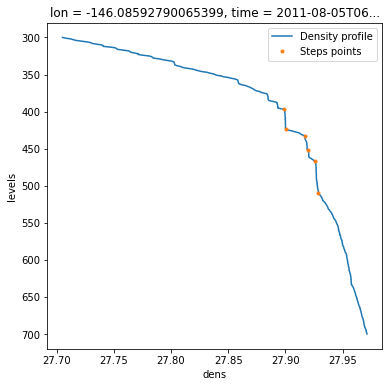

In [18]:
plt.figure(figsize=(6,6))
var.plot(y='levels',yincrease=False,label='Density profile')
rho_g.plot.line('.',y='levels',yincrease=False,label='Steps points')
plt.legend()

In [19]:
#Diags needed : thickness, number of steps, mean thickness
nb_steps = xr.DataArray(np.array([rho_g.levels.size//2]),dims='time',coords={'time':var.time.values.reshape(1,)})
thickness = rho_g.levels.diff(dim='levels')[::2]
mean_thick = xr.DataArray(np.array([thickness.mean()]),dims='time',coords={'time':var.time.values.reshape(1,)})

In [20]:
#Function to extend method to all dataset
def ITP_steps(ds,t,threshold,min_thick,p0,p1):
    dsi = ds.sel(levels=slice(p0,p1))
    var = dsi.dens.sel(time=t,method='nearest')
    drho = var.differentiate('levels')
    rho_th = var.where(drho>threshold,drop=True)
    rho_g = rho_th.where(rho_th.levels.diff(dim='levels')>min_thick,drop=True)
    rho_g = xr.concat([rho_th[np.isin(rho_th.levels.values,rho_g.levels.values)],rho_th[np.roll(np.isin(rho_th.levels.values,rho_g.levels.values),-1)]],dim='levels')
    rho_g = rho_g.sortby('levels')
    if rho_g.size==0:
        nb_steps = xr.DataArray(np.array([0]),dims='time',coords={'time':var.time.values.reshape(1,)})
        mean_thick = xr.DataArray(np.array([np.nan]),dims='time',coords={'time':var.time.values.reshape(1,)})
    else:
        nb_steps = xr.DataArray(np.array([rho_g.levels.size//2]),dims='time',coords={'time':var.time.values.reshape(1,)})
        thickness = rho_g.levels.diff(dim='levels')[::2]
        mean_thick = xr.DataArray(np.array([thickness.mean()]),dims='time',coords={'time':var.time.values.reshape(1,)})
    return xr.Dataset({'nb_steps':nb_steps,'mean_thickness':mean_thick,'lon':var.lon,'lat':var.lat})

In [21]:
steps = xr.concat([xr.concat([ITP_steps(DS[itp],t,threshold_rho,th,300,700) for t in DS[itp].time.values],dim='time')for itp in DS],dim='time')

### Maps of number and mean thickness of steps for each profile

In [22]:
step = steps.where(steps.nb_steps>steps.nb_steps.min(),drop=True)

Text(1073854.4519630666, 667630.5505538966, 'D')

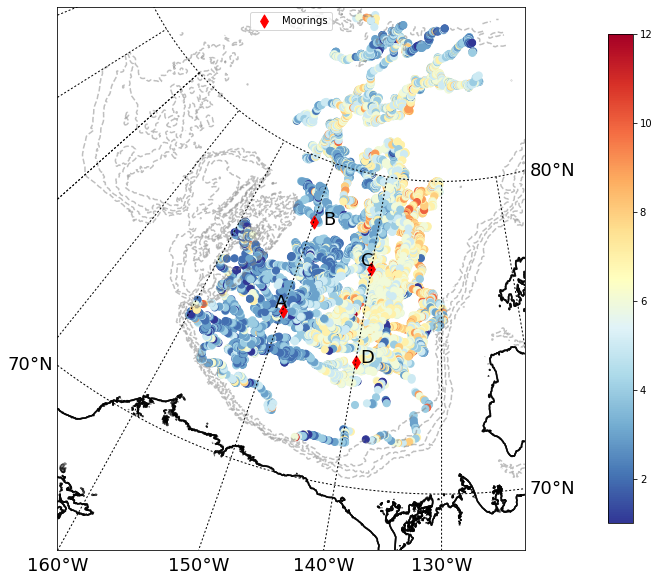

In [23]:
vmin,vmax = step.nb_steps.min(),step.nb_steps.max()
mapcolor=cm.RdYlBu_r
Size=18
fig = plt.figure(figsize=(15, 10) ) 
m = Basemap(width=6000000,height=4500000,resolution='c',projection='aea',lon_0=-130,lat_0=75,llcrnrlon=-160.,llcrnrlat=65.,urcrnrlon=-100.,urcrnrlat=85.)
#m.latmin=60
#m.drawcoastlines(linewidth=0.5)
#m.fillcontinents(color='tan',lake_color='lightblue')
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,91.,10.),labels=[True,True,False,False],dashes=[2,2],fontsize=Size)
m.drawmeridians(np.arange(-180.,181.,10.),labels=[False,False,False,True],dashes=[2,2],fontsize=Size)
#m.drawmapboundary(fill_color='lightblue')
#m.drawcountries(linewidth=2, linestyle='solid', color='k' ) 
#m.drawstates(linewidth=0.5, linestyle='solid', color='k')
#m.drawrivers(linewidth=0.5, linestyle='solid', color='blue')

#Add bathymetry
lat_t,lon_t,topo=topography(file_topo)
lon_topo,lat_topo=np.meshgrid(lon_t,lat_t)
Lon_topo,Lat_topo=m(lon_topo,lat_topo)
m.contour(Lon_topo,Lat_topo,topo,levels=np.arange(-2000,0,500),colors='gray',alpha=0.5)
m.contour(Lon_topo,Lat_topo,topo,levels=np.arange(10,15,1),colors='k',alpha=0.5)

sm=m.scatter(step.lon.values,step.lat.values,s=50,c=step.nb_steps.values,cmap=mapcolor,latlon=True,vmin=vmin,vmax=vmax)
#m.scatter(Tmax_casts.lon.values,Tmax_casts.lat.values,s=50,c=Tmax_casts.values,cmap=mapcolor,latlon=True,vmin=vmin,vmax=vmax)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = cm.ScalarMappable(norm=norm, cmap=mapcolor)
sm.set_array([])
cb = fig.colorbar(sm,orientation='vertical',shrink=0.9,pad=0.1)
m.scatter([-150,-150,-140,-140],[78,75,74,77],s=85,c='r',marker='d',latlon=True,label='Moorings')
plt.legend()
xa,ya=m(-151,75)
xb,yb=m(-148.5,78)
xc,yc=m(-141.5,77.05)
xd,yd=m(-139.5,74)

plt.text(xa,ya,'A',fontsize=Size)
plt.text(xb,yb,'B',fontsize=Size)
plt.text(xc,yc,'C',fontsize=Size)
plt.text(xd,yd,'D',fontsize=Size)

Text(1073854.4519630666, 667630.5505538966, 'D')

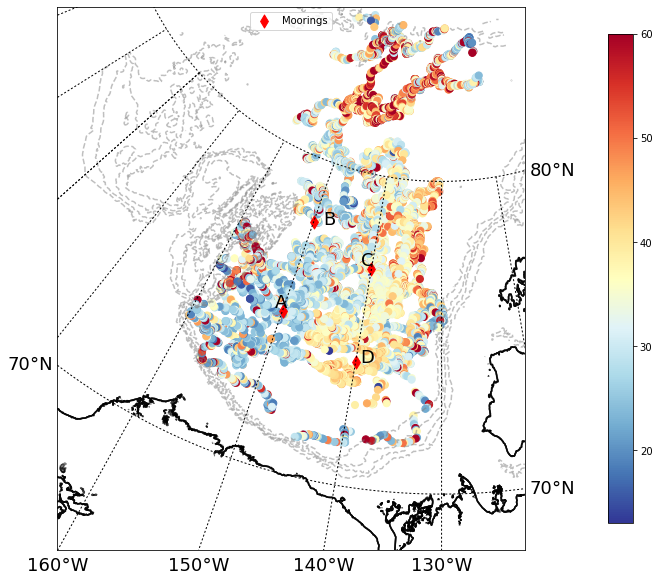

In [24]:
vmin,vmax = step.mean_thickness.min(),60#step.mean_thickness.max()
mapcolor=cm.RdYlBu_r
Size=18
fig = plt.figure(figsize=(15, 10) ) 
m = Basemap(width=6000000,height=4500000,resolution='c',projection='aea',lon_0=-130,lat_0=75,llcrnrlon=-160.,llcrnrlat=65.,urcrnrlon=-100.,urcrnrlat=85.)
#m.latmin=60
#m.drawcoastlines(linewidth=0.5)
#m.fillcontinents(color='tan',lake_color='lightblue')
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,91.,10.),labels=[True,True,False,False],dashes=[2,2],fontsize=Size)
m.drawmeridians(np.arange(-180.,181.,10.),labels=[False,False,False,True],dashes=[2,2],fontsize=Size)
#m.drawmapboundary(fill_color='lightblue')
#m.drawcountries(linewidth=2, linestyle='solid', color='k' ) 
#m.drawstates(linewidth=0.5, linestyle='solid', color='k')
#m.drawrivers(linewidth=0.5, linestyle='solid', color='blue')

#Add bathymetry
lat_t,lon_t,topo=topography(file_topo)
lon_topo,lat_topo=np.meshgrid(lon_t,lat_t)
Lon_topo,Lat_topo=m(lon_topo,lat_topo)
m.contour(Lon_topo,Lat_topo,topo,levels=np.arange(-2000,0,500),colors='gray',alpha=0.5)
m.contour(Lon_topo,Lat_topo,topo,levels=np.arange(10,15,1),colors='k',alpha=0.5)

sm=m.scatter(step.lon.values,step.lat.values,s=50,c=step.mean_thickness.values,cmap=mapcolor,latlon=True,vmin=vmin,vmax=vmax)
#m.scatter(Tmax_casts.lon.values,Tmax_casts.lat.values,s=50,c=Tmax_casts.values,cmap=mapcolor,latlon=True,vmin=vmin,vmax=vmax)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = cm.ScalarMappable(norm=norm, cmap=mapcolor)
sm.set_array([])
cb = fig.colorbar(sm,orientation='vertical',shrink=0.9,pad=0.1)
m.scatter([-150,-150,-140,-140],[78,75,74,77],s=85,c='r',marker='d',latlon=True,label='Moorings')
plt.legend()
xa,ya=m(-151,75)
xb,yb=m(-148.5,78)
xc,yc=m(-141.5,77.05)
xd,yd=m(-139.5,74)

plt.text(xa,ya,'A',fontsize=Size)
plt.text(xb,yb,'B',fontsize=Size)
plt.text(xc,yc,'C',fontsize=Size)
plt.text(xd,yd,'D',fontsize=Size)

### Map of number times mean thickness of steps

Text(1073854.4519630666, 667630.5505538966, 'D')

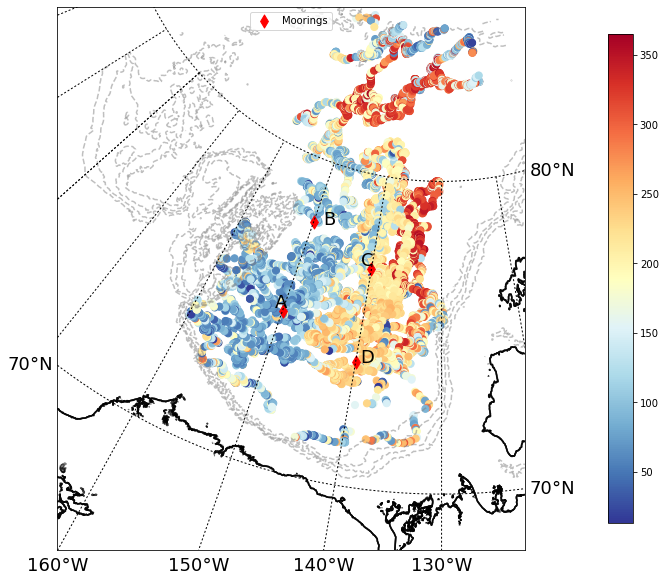

In [25]:
vmin,vmax= (step.nb_steps.values*step.mean_thickness.values).min(),(step.nb_steps.values*step.mean_thickness.values).max()
mapcolor=cm.RdYlBu_r
Size=18
fig = plt.figure(figsize=(15, 10) ) 
m = Basemap(width=6000000,height=4500000,resolution='c',projection='aea',lon_0=-130,lat_0=75,llcrnrlon=-160.,llcrnrlat=65.,urcrnrlon=-100.,urcrnrlat=85.)
#m.latmin=60
#m.drawcoastlines(linewidth=0.5)
#m.fillcontinents(color='tan',lake_color='lightblue')
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,91.,10.),labels=[True,True,False,False],dashes=[2,2],fontsize=Size)
m.drawmeridians(np.arange(-180.,181.,10.),labels=[False,False,False,True],dashes=[2,2],fontsize=Size)
#m.drawmapboundary(fill_color='lightblue')
#m.drawcountries(linewidth=2, linestyle='solid', color='k' ) 
#m.drawstates(linewidth=0.5, linestyle='solid', color='k')
#m.drawrivers(linewidth=0.5, linestyle='solid', color='blue')

#Add bathymetry
lat_t,lon_t,topo=topography(file_topo)
lon_topo,lat_topo=np.meshgrid(lon_t,lat_t)
Lon_topo,Lat_topo=m(lon_topo,lat_topo)
m.contour(Lon_topo,Lat_topo,topo,levels=np.arange(-2000,0,500),colors='gray',alpha=0.5)
m.contour(Lon_topo,Lat_topo,topo,levels=np.arange(10,15,1),colors='k',alpha=0.5)

sm=m.scatter(step.lon.values,step.lat.values,s=50,c=step.nb_steps.values*step.mean_thickness.values,cmap=mapcolor,latlon=True,vmin=vmin,vmax=vmax)
#m.scatter(Tmax_casts.lon.values,Tmax_casts.lat.values,s=50,c=Tmax_casts.values,cmap=mapcolor,latlon=True,vmin=vmin,vmax=vmax)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = cm.ScalarMappable(norm=norm, cmap=mapcolor)
sm.set_array([])
cb = fig.colorbar(sm,orientation='vertical',shrink=0.9,pad=0.1)
m.scatter([-150,-150,-140,-140],[78,75,74,77],s=85,c='r',marker='d',latlon=True,label='Moorings')
plt.legend()
xa,ya=m(-151,75)
xb,yb=m(-148.5,78)
xc,yc=m(-141.5,77.05)
xd,yd=m(-139.5,74)

plt.text(xa,ya,'A',fontsize=Size)
plt.text(xb,yb,'B',fontsize=Size)
plt.text(xc,yc,'C',fontsize=Size)
plt.text(xd,yd,'D',fontsize=Size)

### Temperature maxima  (maps): 

In [26]:
vmin,vmax = 0.6,1.1#0.75-0.75*0.33,0.75+0.75*0.33
DS_sub = {itp : DS[itp].where(DS[itp].pres>300,drop=True) for itp in DS}
DS_sub = {itp : DS_sub[itp].where(DS_sub[itp].pres<700,drop=True) for itp in DS_sub}
Tmax = xr.concat([DS_sub[itp].max('levels').CT for itp in DS],dim='time')
Tmax = Tmax.where(Tmax<vmax,drop=True)
Tmax = Tmax.where(Tmax>vmin,drop=True)

/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


In [27]:
Pmax = xr.concat([DS_sub[itp].where(DS_sub[itp].CT==DS_sub[itp].CT.max('levels'),drop=True).mean('levels').pres for itp in DS],dim='time')

#Pmax = Pmax.mean('levels')

/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/

In [29]:
Tmax_casts = casts.sel(pressure=slice(300,700)).max('pressure').pottemp
Tmax_casts = Tmax_casts.where(Tmax_casts<vmax,drop=True)
Tmax_casts = Tmax_casts.where(Tmax_casts>vmin,drop=True)
#Pmax_casts = xr.concat([casts.sel(time=t,method='nearest').where(casts.sel(time=t,method='nearest').pottemp==casts.sel(time=t,method='nearest').max('pressure').pottemp,drop=True).pressure for t in Tmax.time.values],dim='time')

/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


In [ ]:
Pmax_casts = Pmax_casts.mean('pressure')

### Map with temperature maxima (Fig6 left column)

Text(1073854.4519630666, 667630.5505538966, 'D')

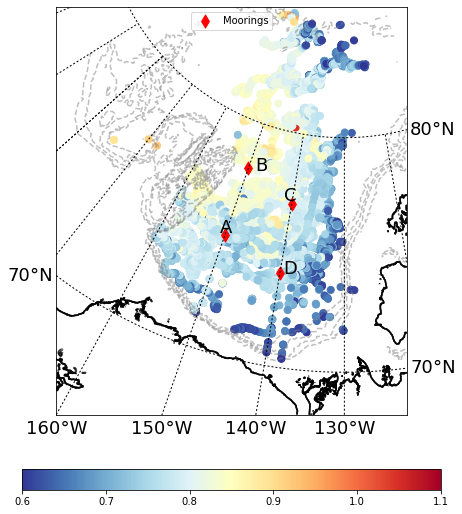

In [31]:
mapcolor=cm.RdYlBu_r
Size=18
fig = plt.figure(figsize=(15, 10) ) 
m = Basemap(width=6000000,height=4500000,resolution='c',projection='aea',lon_0=-130,lat_0=75,llcrnrlon=-160.,llcrnrlat=65.,urcrnrlon=-100.,urcrnrlat=85.)
#m.latmin=60
#m.drawcoastlines(linewidth=0.5)
#m.fillcontinents(color='tan',lake_color='lightblue')
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,91.,10.),labels=[True,True,False,False],dashes=[2,2],fontsize=Size)
m.drawmeridians(np.arange(-180.,181.,10.),labels=[False,False,False,True],dashes=[2,2],fontsize=Size)
#m.drawmapboundary(fill_color='lightblue')
#m.drawcountries(linewidth=2, linestyle='solid', color='k' ) 
#m.drawstates(linewidth=0.5, linestyle='solid', color='k')
#m.drawrivers(linewidth=0.5, linestyle='solid', color='blue')

#Add bathymetry
lat_t,lon_t,topo=topography(file_topo)
lon_topo,lat_topo=np.meshgrid(lon_t,lat_t)
Lon_topo,Lat_topo=m(lon_topo,lat_topo)
m.contour(Lon_topo,Lat_topo,topo,levels=np.arange(-2000,0,500),colors='gray',alpha=0.5)
m.contour(Lon_topo,Lat_topo,topo,levels=np.arange(10,15,1),colors='k',alpha=0.5)

sm=m.scatter(Tmax.lon.values,Tmax.lat.values,s=50,c=Tmax.values,cmap=mapcolor,latlon=True,vmin=vmin,vmax=vmax)
m.scatter(Tmax_casts.lon.values,Tmax_casts.lat.values,s=50,c=Tmax_casts.values,cmap=mapcolor,latlon=True,vmin=vmin,vmax=vmax)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = cm.ScalarMappable(norm=norm, cmap=mapcolor)
sm.set_array([])
cb = fig.colorbar(sm,orientation='horizontal',shrink=0.5,pad=0.1)
m.scatter([-150,-150,-140,-140],[78,75,74,77],s=85,c='r',marker='d',latlon=True,label='Moorings')
plt.legend()
xa,ya=m(-151,75)
xb,yb=m(-148.5,78)
xc,yc=m(-141.5,77.05)
xd,yd=m(-139.5,74)

plt.text(xa,ya,'A',fontsize=Size)
plt.text(xb,yb,'B',fontsize=Size)
plt.text(xc,yc,'C',fontsize=Size)
plt.text(xd,yd,'D',fontsize=Size)

### Map level at which the temperature maximum is found (Fig6 right column)

Text(1073854.4519630666, 667630.5505538966, 'D')

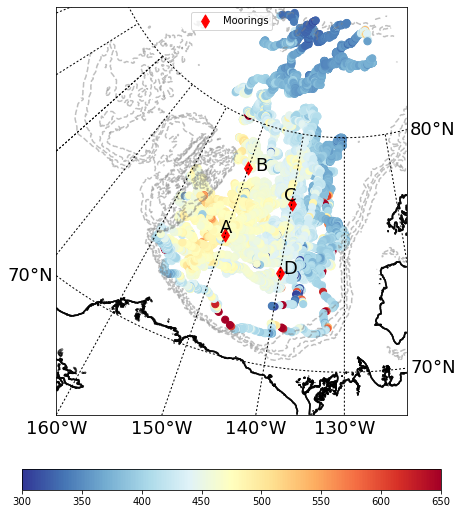

In [33]:
mapcolor=cm.RdYlBu_r
Size=18
vmin=300
vmax=650
fig = plt.figure(figsize=(15, 10) ) 
m = Basemap(width=6000000,height=4500000,resolution='c',projection='aea',lon_0=-130,lat_0=75,llcrnrlon=-160.,llcrnrlat=65.,urcrnrlon=-100.,urcrnrlat=85.)
#m.latmin=60
#m.drawcoastlines(linewidth=0.5)
#m.fillcontinents(color='tan',lake_color='lightblue')
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,91.,10.),labels=[True,True,False,False],dashes=[2,2],fontsize=Size)
m.drawmeridians(np.arange(-180.,181.,10.),labels=[False,False,False,True],dashes=[2,2],fontsize=Size)
#m.drawmapboundary(fill_color='lightblue')
#m.drawcountries(linewidth=2, linestyle='solid', color='k' ) 
#m.drawstates(linewidth=0.5, linestyle='solid', color='k')
#m.drawrivers(linewidth=0.5, linestyle='solid', color='blue')

#Add bathymetry
lat_t,lon_t,topo=topography(file_topo)
lon_topo,lat_topo=np.meshgrid(lon_t,lat_t)
Lon_topo,Lat_topo=m(lon_topo,lat_topo)
m.contour(Lon_topo,Lat_topo,topo,levels=np.arange(-2000,0,500),colors='gray',alpha=0.5)
m.contour(Lon_topo,Lat_topo,topo,levels=np.arange(10,15,1),colors='k',alpha=0.5)

sm=m.scatter(Pmax.lon.values,Pmax.lat.values,s=50,c=Pmax.values,cmap=mapcolor,latlon=True,vmin=vmin,vmax=vmax)
#m.scatter(Pmax_casts.lon.values,Pmax_casts.lat.values,s=50,c=Pmax_casts.values,cmap=mapcolor,latlon=True,vmin=vmin,vmax=vmax)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = cm.ScalarMappable(norm=norm, cmap=mapcolor)
sm.set_array([])
cb = fig.colorbar(sm,orientation='horizontal',shrink=0.5,pad=0.1)
m.scatter([-150,-150,-140,-140],[78,75,74,77],s=85,c='r',marker='d',latlon=True,label='Moorings')
plt.legend()
xa,ya=m(-151,75)
xb,yb=m(-148.5,78)
xc,yc=m(-141.5,77.05)
xd,yd=m(-139.5,74)

plt.text(xa,ya,'A',fontsize=Size)
plt.text(xb,yb,'B',fontsize=Size)
plt.text(xc,yc,'C',fontsize=Size)
plt.text(xd,yd,'D',fontsize=Size)